# Infor

1. Following the protocol of data collector, the scenario distribution for cut-in case can only be accessed by reseanable request for now.

2. To reproduce the figures, please download the results from 
https://drive.google.com/file/d/11uOygVF7MAphVHqPobqq9A42c7u4jjih/view?usp=sharing

In [1]:
import sys
sys.path.append("../../")

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation
from scipy.interpolate import interp1d

from examples.cutin.cutin import value_function_IDM, value_function_FVDM 

In [3]:
plt.rcParams.update({'font.size': 16})

# 1. Response function

In [5]:
def f_h(x, dt=0.2, STEP=50):
    x = np.array(x)
    if x.ndim == 1:
        return value_function_IDM(x, dt=dt, STEP=STEP)
    if x.ndim == 2:
        return np.array([value_function_IDM(i, dt=dt, STEP=STEP) for i in x])

def f_l(x, dt, STEP):
    x = np.array(x)
    if x.ndim == 1:
        return value_function_FVDM(x, dt=dt, STEP=STEP)
    if x.ndim == 2:
        return np.array([value_function_FVDM(i, dt=dt, STEP=STEP) for i in x])

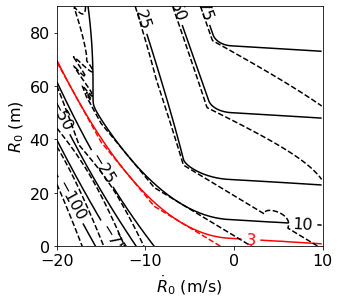

In [9]:
x = np.arange(-20,10,0.1) # this is rate
y = np.arange(0, 90,0.2)   # this is range
x_mesh, y_mesh = np.meshgrid(x, y)

z_h = np.array([[f_h([j,i]) for i in x] for j in y])
z_l_2 = np.array([[f_h([j,i], 2, 5) for i in x] for j in y])

plt.figure(figsize=(5,4.5))
cs1 = plt.contour(x_mesh, y_mesh, z_h, levels=[-100, -75, -50, -25, 10, 25, 50, 75], 
                  colors='black', linestyles='solid')
cs2 = plt.contour(x_mesh, y_mesh, z_h, levels=[3], colors='red', linestyles='solid')
cs3 = plt.contour(x_mesh, y_mesh, z_l_2, levels=[-100, -75, -50, -25, 10, 25, 50, 75], 
                  colors='black', linestyles='dashed')
cs4 = plt.contour(x_mesh, y_mesh, z_l_2, levels=[3], colors='red', linestyles='dashed')

plt.clabel(cs1)
plt.clabel(cs2)
plt.xlabel('$\dot{R}_{0}$ (m/s)')
plt.ylabel('$R_{0}$ (m)')
plt.xticks([-20,-10,0,10])
plt.tight_layout()
plt.savefig('figures/f_h_l_contour.pdf')
plt.show()

# 2. Results

In [11]:
# load the raw results

results_sgp = np.load('results/sf_delta_3.npy')

# postfix representing number of steps 
results_bfgp_2 = np.load('results/bf_2.npy', allow_pickle=True)
results_bfgp_5 = np.load('results/bf_5.npy', allow_pickle=True)
results_bfgp_10 = np.load('results/bf_10.npy', allow_pickle=True)
results_bfgp_20 = np.load('results/bf_20.npy', allow_pickle=True)

In [13]:
# functions to generate plotting data from raw results

def compute_tf_cost(X_list, c_ratio, full_return=False):
    cost_list = np.zeros(len(X_list))
    if not full_return:
        for ii, X in enumerate(X_list):
            num_h_X = np.count_nonzero(X[:,-1]==1)
            num_l_X = np.count_nonzero(X[:,-1]==0)
            cost_list[ii] = num_h_X +  1 / c_ratio * num_l_X
        return cost_list
    else:
        cost_list_h = np.zeros(len(X_list))
        cost_list_l = np.zeros(len(X_list))
        for ii, X in enumerate(X_list):
            num_h_X = np.count_nonzero(X[:,-1]==1)
            num_l_X = np.count_nonzero(X[:,-1]==0)
            cost_l = 1 / c_ratio * num_l_X
            cost_list[ii] = num_h_X + cost_l
            cost_list_h[ii] = num_h_X
            cost_list_l[ii] = cost_l
        return cost_list, cost_list_h, cost_list_l

def generate_plotdata(result_runs, c_ratio, fixed_quato=False):

    error_list_runs = [result[1] for result in result_runs]
    if fixed_quato:
        cost_list = compute_tf_cost(result_runs[0][0], c_ratio)
    else:
        # compute the range for cost_list
        cost_list_runs = [compute_tf_cost(result[0], c_ratio) 
                                            for result in result_runs]
        end1 =  np.max([cost_list[0] for cost_list in cost_list_runs])
        end2 = np.min([cost_list[-1] for cost_list in cost_list_runs])
        cost_list = np.arange(end1, end2, 0.2)
        # re-compute the error
        error_list_runs = [interp1d(i,j)(cost_list) 
                                for i,j in zip(cost_list_runs, error_list_runs)]
    return cost_list, np.asarray(error_list_runs, float)

In [23]:
# Generate the plotting data
x_2, y_2 = generate_plotdata(results_bfgp_2, 25, fixed_quato=False)
x_5, y_5 = generate_plotdata(results_bfgp_5, 10, fixed_quato=False)
x_10, y_10 = generate_plotdata(results_bfgp_10, 5, fixed_quato=False)
x_20, y_20 = generate_plotdata(results_bfgp_20, 2.5, fixed_quato=False)

y_20, y_10, y_5, y_2 = (y_20.astype(float), y_10.astype(float), 
                        y_5.astype(float), y_2.astype(float))

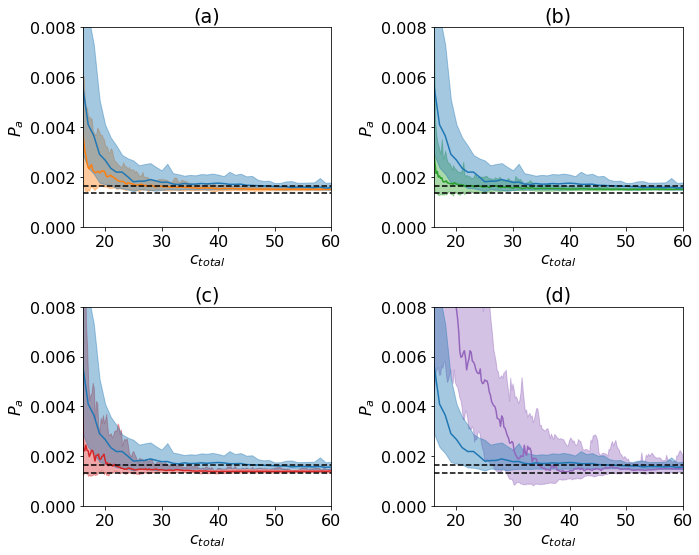

In [31]:
fig, axes = plt.subplots(2,2, figsize=(10,8))
ax1, ax2, ax3, ax4 = (axes[0][0], axes[0][1], 
                             axes[1][0], axes[1][1])
ax1.set_title('(a)')
ax1.plot(x_20, np.median(y_20, axis=0), color='tab:orange')
ax1.fill_between(x_20, np.percentile(y_20, 15, axis=0), 
                 np.percentile(y_20, 85, axis=0),
                 alpha=0.4, color='tab:orange')

ax2.set_title('(b)')
ax2.plot(x_10, np.median(y_10, axis=0), color='tab:green')
ax2.fill_between(x_10, np.percentile(y_10, 15, axis=0), 
                 np.percentile(y_10, 85, axis=0),
                 alpha=0.4, color='tab:green')

ax3.set_title('(c)')
ax3.plot(x_5, np.median(y_5, axis=0), color='tab:red')
ax3.fill_between(x_5, np.percentile(y_5, 15, axis=0), 
                 np.percentile(y_5, 85, axis=0),
                 alpha=0.4, color='tab:red')

ax4.set_title('(d)')
ax4.plot(x_2, np.median(y_2, axis=0), color='tab:purple')
ax4.fill_between(x_2, np.percentile(y_2, 15, axis=0), 
                 np.percentile(y_2, 85, axis=0),
                 alpha=0.4, color='tab:purple')



for ax in ax1, ax2, ax3, ax4:
    ax.plot(np.arange(16,101), np.median(results_sgp, axis=0), color='tab:blue')
    ax.fill_between(np.arange(16, 101), np.percentile(results_sgp, 15, axis=0), 
                 np.percentile(results_sgp, 85, axis=0),
                 alpha=0.4, color='tab:blue')

    ax.plot(np.arange(16,61), [0.00149 * 1.1] * len(np.arange(16,61)), 'k--')
    ax.plot(np.arange(16,61), [0.00149 * 0.9] * len(np.arange(16,61)), 'k--')
    ax.set_xlabel('$c_{total}$')
    ax.set_ylabel('$P_a$')
    ax.set_ylim(0, 0.008)
    ax.set_xlim(16, 60)

plt.tight_layout()
plt.savefig('figures/convergence_bf.pdf')
plt.show()